# Social media image retrieval prototype

Dataset: https://www.kaggle.com/prithvijaunjale/instagram-images-with-captions

- 1 of 2 proposed solutions
- based on MobileNet, a CNN model that performs well on CPU, and on Annoy, Spotify's indexing and similarity search library
- post retrival times are around 0.05s - 0.07s / search on average, given circa 20K captions. This could be improved by using more computational power
- search results seem relevant, though no formal evaluation has been conducted

### Potential improvements:

- automated image captioning can be used for additional feature extraction (e.g. using VilBERT)
- dual (text-image) encoding can be employed, though Instagram posts captions don't always match images in meanings
- more information can be extracted from images (e.g using graph scene generation or more advanced visual transformers)


In [21]:
# install packages if not installed
! pip install annoy

ERROR: Could not find a version that satisfies the requirement ZipFile (from versions: none)
ERROR: No matching distribution found for ZipFile


In [78]:
# import packages
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image
from annoy import AnnoyIndex
import os
import time
#TF
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential,Model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Dense,Conv2D,Flatten,Dropout, Input, Concatenate, BatchNormalization
#other
import pickle
import zipfile

In [23]:
# unzip file, if needed
#with zipfile.ZipFile("img.zip","r") as zip_ref:
#    zip_ref.extractall("./img")

In [11]:
#Find Images in the Root Directiry and making list of those Images
extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']
def get_file_list(root_dir):
    file_list = []
    counter = 1
    for root, directories, filenames in os.walk(root_dir):
        for filename in filenames:
            if any(ext in filename for ext in extensions):
                file_list.append(os.path.join(root, filename))
                counter += 1
    return file_list

In [12]:
# get filenames into a list
root_dir = './img/img'
filenames = sorted(get_file_list(root_dir))
print(f"There are {len(filenames)} images")

There are 20515 images


In [13]:
# define functions
# using MobileNet V2, a CNN designed for mobile devices, as it doesn't require GPU
# and performs efficiently on CPU
def MobileNet_model():
    base_model = keras.applications.mobilenet_v2.MobileNetV2(weights="imagenet")
    avg_pool_name = [l.name for l in base_model.layers][-2]
    x = base_model.get_layer(avg_pool_name).output
    model = Model(inputs=base_model.input, outputs=x)
    return model

# preprocess images and generate embeddings
def img_yield(pathes, batch_size=32, size=(224,224)):
    for i in tqdm(range(len(pathes) // batch_size+1)):
        imgs = []
        batch_pathes = pathes[i*batch_size : (1+i)*batch_size]
        if len(batch_pathes)==0: break
        for path in batch_pathes:
            img = load_img(path, target_size=size)
            img = tf.keras.applications.mobilenet_v2.preprocess_input(np.array(img))
            imgs.append(img)
        yield np.array(imgs)

In [17]:
# initiate model
model = MobileNet_model()
# initiate "pipeline"
embed_imgs = model.predict(img_yield(filenames))
# check shape
embed_imgs.shape

  0%|          | 0/642 [00:00<?, ?it/s]

(20515, 1280)

In [19]:
# initiate annoy index model
annoy_model = AnnoyIndex(embed_imgs.shape[1])
# map embedding to annoy indices
for i, embed in enumerate(embed_imgs):
    annoy_model.add_item(i, embed)
annoy_model.build(i)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  


True

In [20]:
# define image retrieval function
def showImg(ids):
    imgs = [Image.open(filenames[i]) for i in ids]
    fig, axes = plt.subplots(1, 5, figsize=(20,8))
    for i, ax in zip(range(5), axes.ravel()):
        ax.set_title(i+1)
        ax.imshow(imgs[i])
        if i == 0:
            ax.set_title(f"Query")
        else:
            ax.set_title(f"Result {i}")
        ax.axis("off")
    plt.show()

>>>> Results in Total Time: 0.05259561538696289
IDs:  [11111, 11910, 12784, 13551, 15066]
Respective distances:  [0.0, 0.7798870205879211, 0.795936644077301, 0.8028643131256104, 0.8065812587738037]


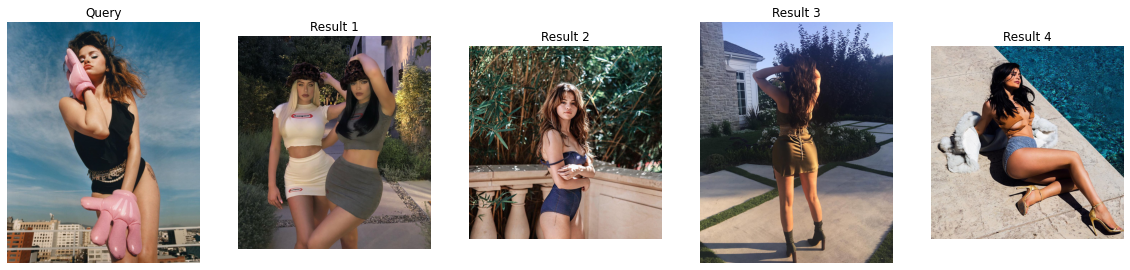

In [81]:
# search within database within miliseconds, based on database IDs
# define target ID
target_ID = 11111
top_n = 5
t=time.time()

ids, distance = annoy_model.get_nns_by_item(target_ID, top_n, include_distances=True)
print('>>>> Results in Total Time: {}'.format(time.time()-t))
print("IDs: ", ids)
print("Respective distances: ", distance)

# visualize
showImg(ids)

>>>> Results in Total Time: 0.04969167709350586
IDs:  [600, 603, 605, 443, 3966]
Respective distances:  [0.0, 0.6420587301254272, 0.7840913534164429, 0.8025752902030945, 0.8376540541648865]


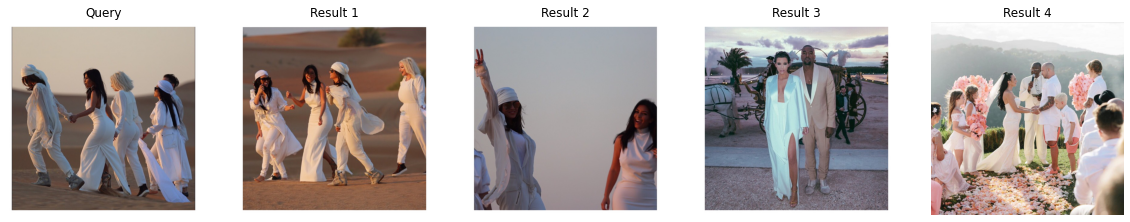

In [82]:
# search within database within miliseconds, based on database IDs
# define target ID
target_ID = 600
top_n = 5
t=time.time()

ids, distance = annoy_model.get_nns_by_item(target_ID, top_n, include_distances=True)
print('>>>> Results in Total Time: {}'.format(time.time()-t))
print("IDs: ", ids)
print("Respective distances: ", distance)

# visualize
showImg(ids)

>>>> Results in Total Time: 0.049837589263916016
IDs:  [8881, 12496, 12014, 12224, 8910]
Respective distances:  [0.0, 0.745781660079956, 0.7559499144554138, 0.7563406229019165, 0.7668666243553162]


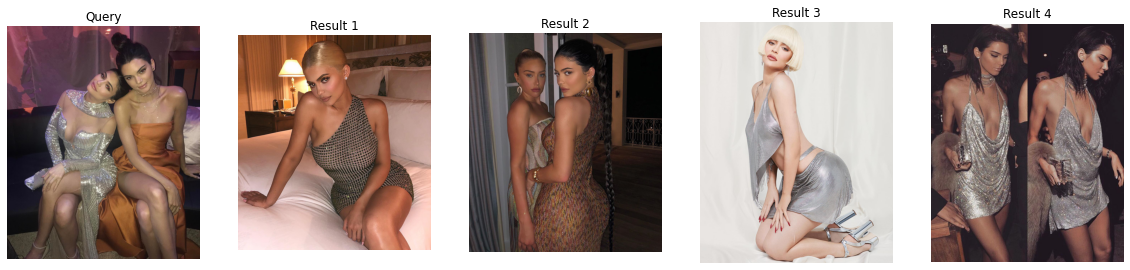

In [83]:
# search within database within miliseconds, based on database IDs
# define target ID
target_ID = 8881
top_n = 5
t=time.time()

ids, distance = annoy_model.get_nns_by_item(target_ID, top_n, include_distances=True)
print('>>>> Results in Total Time: {}'.format(time.time()-t))
print("IDs: ", ids)
print("Respective distances: ", distance)

# visualize
showImg(ids)

>>>> Results in Total Time: 0.0418245792388916
IDs:  [7891, 9239, 5738, 7257, 6846]
Respective distances:  [0.0, 0.8140144944190979, 0.8472699522972107, 0.8502072095870972, 0.8654208779335022]


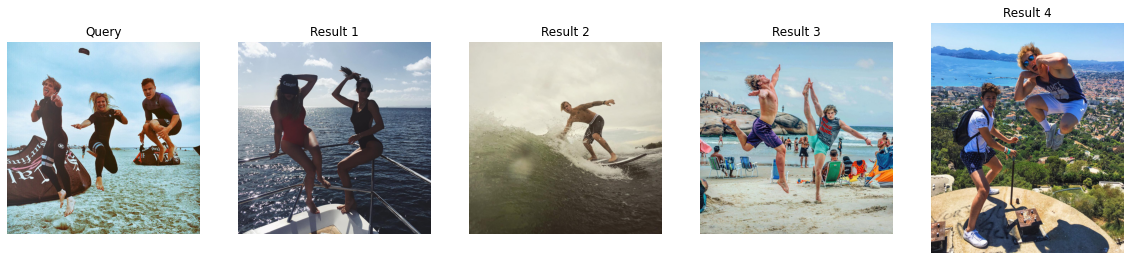

In [84]:
# search within database within miliseconds, based on database IDs
# define target ID
target_ID = 7891
top_n = 5
t=time.time()

ids, distance = annoy_model.get_nns_by_item(target_ID, top_n, include_distances=True)
print('>>>> Results in Total Time: {}'.format(time.time()-t))
print("IDs: ", ids)
print("Respective distances: ", distance)

# visualize
showImg(ids)

>>>> Results in Total Time: 0.0688014030456543
IDs:  [16986, 10763, 11901, 12395, 15]
Respective distances:  [0.0, 0.7511587738990784, 0.8576393723487854, 0.8624330759048462, 0.8629580140113831]


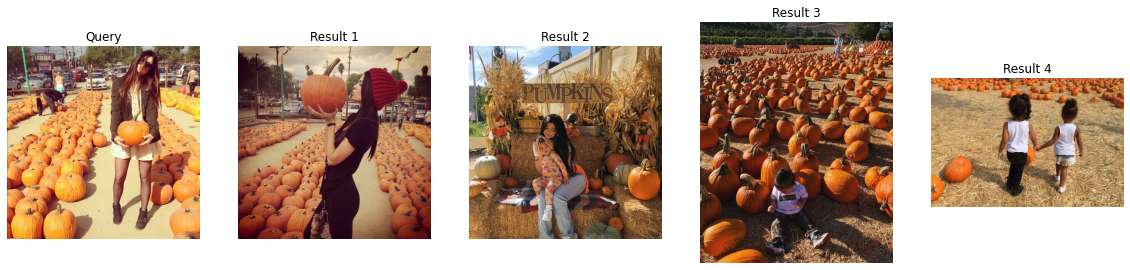

In [79]:
# search within database within miliseconds, based on database IDs
# define target ID
target_ID = 16986
top_n = 5
t=time.time()

ids, distance = annoy_model.get_nns_by_item(target_ID, top_n, include_distances=True)
print('>>>> Results in Total Time: {}'.format(time.time()-t))
print("IDs: ", ids)
print("Respective distances: ", distance)

# visualize
showImg(ids)